In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from glob import glob
from IPython.display import clear_output

%matplotlib inline

In [2]:
# Directory of spectrograms
data_dir = 'data_images/'

In [3]:
# Infer genres from contents
genre_list = os.listdir(data_dir)
num_features = len(genre_list)
genre_list

['blues', 'house', 'metal_death', 'metal_heavy', 'rnb']

In [4]:
from tensorflow.keras.preprocessing.image import load_img

In [5]:
# Load png files and label them for training

data = []
labels = []

l = 0
for genre in genre_list:
    clear_output(wait=True)
    print(l,genre)
    for i in glob(data_dir + genre + '/*'):   
        image = load_img(i, color_mode='grayscale', 
        target_size = (100,100))
        image = np.array(image)
        data.append(image)
        labels.append(l)
    l += 1
    
data = np.array(data)
labels = np.array(labels)

4 rnb


In [6]:
data.shape

(6988, 100, 100)

In [7]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

In [8]:
# Scale features
X_train = X_train/255
X_test = X_test/255

In [9]:
len(X_train)

5590

In [10]:
len(X_test)

1398

In [11]:
# Reshape with additional feature dimension
X_train = X_train.reshape(len(X_train), 100, 100, 1)
X_test = X_test.reshape(len(X_test), 100, 100, 1)

In [12]:
X_train.shape

(5590, 100, 100, 1)

In [13]:
y_train

array([4, 1, 2, ..., 1, 2, 2])

In [14]:
from tensorflow.keras.utils import to_categorical

In [15]:
# One-hot encode labels
y_cat_train = to_categorical(y_train)
y_cat_test = to_categorical(y_test)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [17]:
# Create CNN model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(100,100,1), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

# Multi-class classification output layer
model.add(Dense(num_features,activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0

In [19]:
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tqdm.keras import TqdmCallback
from datetime import datetime

In [20]:
# Prevent overfitting
early_stop = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)

In [21]:
# Optional: Use TensorBoard
timestamp = datetime.now().strftime("%Y-%m-%d--%H%M")
log_directory = 'logs\\fit__5_genres'
log_directory = log_directory + '\\' + timestamp
if(not os.path.exists(log_directory)):
    os.makedirs(log_directory)

board = TensorBoard(log_dir=log_directory,histogram_freq=2,
    write_graph=False,
    write_images=False,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

In [22]:
# Train model
model.fit(x=X_train,y=y_cat_train,
          batch_size=16,
          epochs=100,
          validation_data=(X_test,y_cat_test),
          verbose=0,
          callbacks=[early_stop,TqdmCallback(verbose=1),board])

In [23]:
losses = pd.DataFrame(model.history.history)

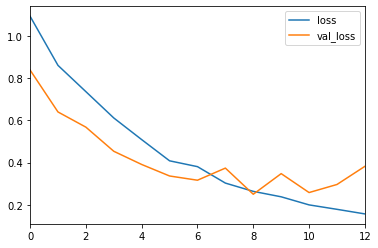

In [24]:
losses[['loss','val_loss']].plot()

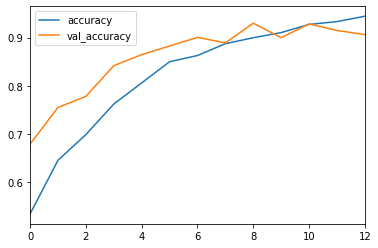

In [25]:
losses[['accuracy','val_accuracy']].plot()

In [26]:
# model.save('CNN_multi-class__5_genres_210106.h5')

In [27]:
from sklearn.metrics import classification_report,confusion_matrix

In [28]:
predictions = model.predict_classes(X_test)

In [29]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       284
           1       0.93      0.88      0.91       270
           2       0.94      0.91      0.92       304
           3       0.93      0.95      0.94       287
           4       0.96      0.96      0.96       253

    accuracy                           0.93      1398
   macro avg       0.93      0.93      0.93      1398
weighted avg       0.93      0.93      0.93      1398



In [30]:
cm = confusion_matrix(y_test,predictions) #+1

In [31]:
from matplotlib.colors import LogNorm

(5.0, 0.0)

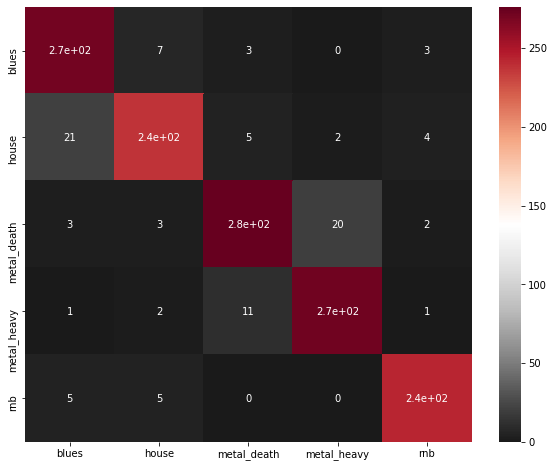

In [32]:
# Beautify confusion matri with correct labels
fig = plt.figure(figsize=(10,8))
ax = fig.gca()

sns.heatmap(cm,annot=True,ax=ax,cmap='RdGy_r')

ax.set_xticklabels(genre_list)
ax.set_yticklabels(genre_list)

bottom,top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

Prediction:  rnb
Confidence:  0.5115164
 
Correct answer:  rnb


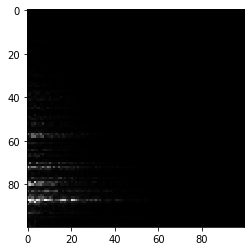

In [33]:
# Test example image
num = 853
random_image = X_test[num]
pred = model.predict_classes(random_image.reshape(1,100,100,1))[0]
print('Prediction: ', genre_list[pred] )
print('Confidence: ', model.predict(random_image.reshape(1,100,100,1))[0,pred] )
print(' ')
print('Correct answer: ', genre_list[y_test[num]])
plt.imshow(random_image.reshape(100,100),cmap='Greys_r')

In [69]:
# Test: Predict Test song not included in train/test data
test_song = []

test_name = 'kataklysm'

for i in glob('data_images_test/' + test_name + '/*'):   
    image = load_img(i, color_mode='grayscale', 
    target_size = (100,100))
    image = np.array(image)
    test_song.append(image)
    
test_song = np.array(test_song)

In [70]:
test_song = test_song/255
test_song = test_song.reshape(len(test_song),100,100,1)

In [71]:
test_song_pred = model.predict_classes(test_song)

In [72]:
np.bincount(test_song_pred)

array([ 0,  0, 17,  3,  2], dtype=int64)

In [73]:
np.bincount(test_song_pred)/len(test_song_pred)

array([0.        , 0.        , 0.77272727, 0.13636364, 0.09090909])

In [74]:
model.predict(test_song).sum(axis=0)/len(test_song_pred)

array([7.29421852e-04, 8.59501961e-06, 8.00699949e-01, 1.08388424e-01,
       9.01736096e-02], dtype=float32)